# Deep learning Classifier

Train a classifier to recognize if I'm running or walking

## Data loading and solve unbalanced dataset problem

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
os.chdir("../")
from data_preprocessing.create_dataset import DatasetGlobalAcc
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.ticker import PercentFormatter
import pandas as pd

In [2]:
from tensorflow.keras.layers import Conv2D, Dropout, Input, Dense, MaxPool2D, Flatten
from tensorflow.keras.models import Model

In [3]:
sequence_size = 20
batch_size = 1024
path_data = "data/clean/"

In [4]:
xtrain = DatasetGlobalAcc(sequence_length=sequence_size, batch_size=batch_size, amplitude=4, scale_batch=False)
xtrain.add_folder(path_data)

In [5]:
def vis_metrics(hist, metric):
    if metric in hist.history.keys():
        plt.plot(hist.history[metric], label="training")
        plt.plot(hist.history['val_' + metric], label="validation")
        plt.title('model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(10, 4)

In [6]:
def scale_batch(batch):
    """Divide each record by the max"""
    m = np.max(np.abs(batch), axis=(1,2,3))
    for i in range(sequence_size):
        batch[:,0, i, 0] /= m   
    return batch

## Build the sample

In [7]:
xtest, ytest = xtrain.get_validation_data(0.2)
xtest = np.expand_dims(xtest, axis=1)

xval, yval = xtrain.get_validation_data(0.2)
xval = np.expand_dims(xval, axis=1)

In [8]:
_ = np.where(xtrain.y == 1)  #
xtrain.x = np.concatenate([xtrain.x, xtrain.x[_]], axis=0)
xtrain.y = np.concatenate([xtrain.y, xtrain.y[_]], axis=0)

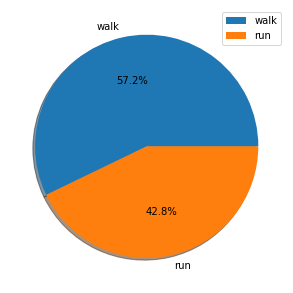

In [9]:
plt.pie([xtrain.y.shape[0] - np.sum(xtrain.y), np.sum(xtrain.y)], labels=('walk', "run"), shadow=True, autopct='%1.1f%%')
fig = plt.gcf()
plt.legend()
fig.set_size_inches(5, 6)

## Build conv

In [10]:
def build_conv(sequence_size):
    """"""
    inputs = Input((1, sequence_size, 1), name="input_layers")
    
    
    x = Conv2D(kernel_size=(2,1), strides=1, activation="relu", padding="same", filters=8)(inputs)
    x = MaxPool2D((1,2))(x)
    x = Dropout(0.1)(x)
    x = Conv2D(kernel_size=(2,1), strides=1, activation="relu", padding="same", filters=16)(x)
    x = MaxPool2D((1,2))(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid", name="output_layer")(x)
    
    return Model(inputs, x, name="convolutional")

In [11]:
cnn = build_conv(sequence_size)
cnn.summary()

Model: "convolutional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layers (InputLayer)    [(None, 1, 20, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 20, 8)          24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 10, 8)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 10, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 10, 16)         272       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 5, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 5, 16)        

In [12]:
cnn.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer="adam")
hist = cnn.fit(x=xtrain, steps_per_epoch=2000, epochs=10,validation_data=(xval, yval))

Epoch 1/10
2000/2000 [==============================] - 23s 12ms/step - loss: 0.3470 - accuracy: 0.8453 - val_loss: 0.1676 - val_accuracy: 0.9441
Epoch 2/10
2000/2000 [==============================] - 23s 11ms/step - loss: 0.2363 - accuracy: 0.9082 - val_loss: 0.1433 - val_accuracy: 0.9538
Epoch 3/10
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2233 - accuracy: 0.9133 - val_loss: 0.1339 - val_accuracy: 0.9567
Epoch 4/10
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2173 - accuracy: 0.9157 - val_loss: 0.1295 - val_accuracy: 0.9583
Epoch 5/10
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2140 - accuracy: 0.9172 - val_loss: 0.1273 - val_accuracy: 0.9610
Epoch 6/10
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2122 - accuracy: 0.9180 - val_loss: 0.1242 - val_accuracy: 0.9607
Epoch 7/10
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2122 - accuracy: 0.9179 - val_loss: 0.1267 -

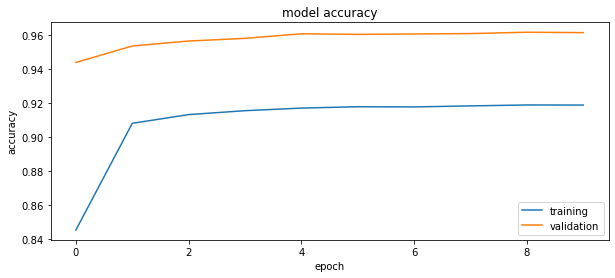

In [13]:
vis_metrics(hist=hist, metric="accuracy")

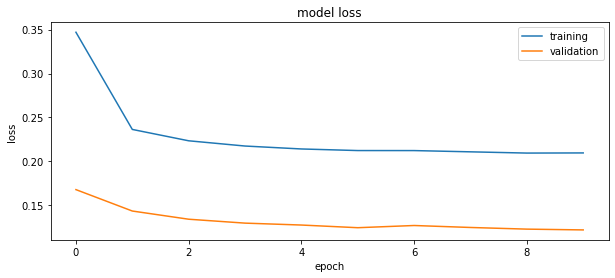

In [14]:
vis_metrics(hist=hist, metric="loss")

In [15]:
cnn.evaluate(xtest, ytest)

347/347 [==============================] - 0s 1ms/step - loss: 0.1322 - accuracy: 0.9533


[0.13217294216156006, 0.9532912373542786]

In [16]:
confusion_matrix(ytest,np.where(cnn.predict(xtest) >.5, 1, 0))

array([[7853,  203],
       [ 315, 2719]])

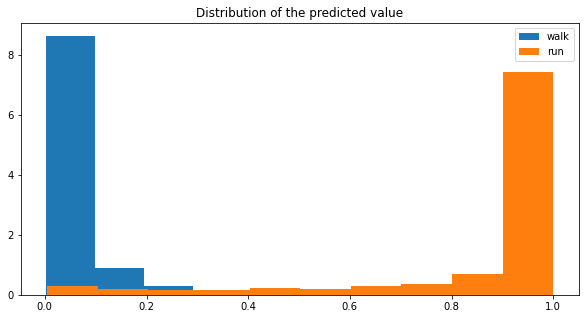

In [17]:
_ = plt.hist(cnn.predict(xtest)[np.where(ytest == 0.)[0]], label="walk", density=True)
_ = plt.hist(cnn.predict(xtest)[np.where(ytest == 1.)[0]], label="run", density=True)
_ = plt.title("Distribution of the predicted value")
_ = plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [18]:
cnn.save("analysis/trained_model/global.h5")

## Scale the data

In [19]:
xtrain.set_scale_batch(True)
xtest2 = scale_batch(xtest)

In [20]:
cnn_scale = build_conv(sequence_size)

In [21]:
cnn_scale.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer="adam")
hist = cnn_scale.fit(x=xtrain, steps_per_epoch=3000, epochs=10, validation_data=(scale_batch(xval), yval), verbose=1)

Epoch 1/10
3000/3000 [==============================] - 34s 11ms/step - loss: 0.5291 - accuracy: 0.7339 - val_loss: 0.4391 - val_accuracy: 0.8312
Epoch 2/10
3000/3000 [==============================] - 33s 11ms/step - loss: 0.4962 - accuracy: 0.7616 - val_loss: 0.4403 - val_accuracy: 0.8383
Epoch 3/10
3000/3000 [==============================] - 33s 11ms/step - loss: 0.4896 - accuracy: 0.7657 - val_loss: 0.4383 - val_accuracy: 0.8378
Epoch 4/10
3000/3000 [==============================] - 34s 11ms/step - loss: 0.4878 - accuracy: 0.7664 - val_loss: 0.4333 - val_accuracy: 0.8377
Epoch 5/10
3000/3000 [==============================] - 35s 12ms/step - loss: 0.4867 - accuracy: 0.7670 - val_loss: 0.4388 - val_accuracy: 0.8372
Epoch 6/10
3000/3000 [==============================] - 35s 12ms/step - loss: 0.4857 - accuracy: 0.7673 - val_loss: 0.4423 - val_accuracy: 0.8372
Epoch 7/10
3000/3000 [==============================] - 35s 12ms/step - loss: 0.4853 - accuracy: 0.7670 - val_loss: 0.4393 -

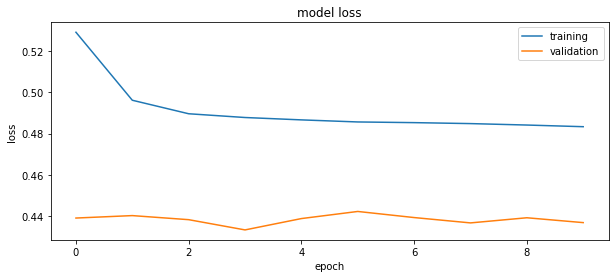

In [22]:
vis_metrics(hist=hist, metric="loss")

In [23]:
cnn_scale.evaluate(xtest2, ytest)

347/347 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.8344


[0.44064247608184814, 0.8343552947044373]

In [24]:
confusion_matrix(ytest,np.where(cnn_scale.predict(xtest2) >.5, 1, 0))

array([[7721,  335],
       [1502, 1532]])

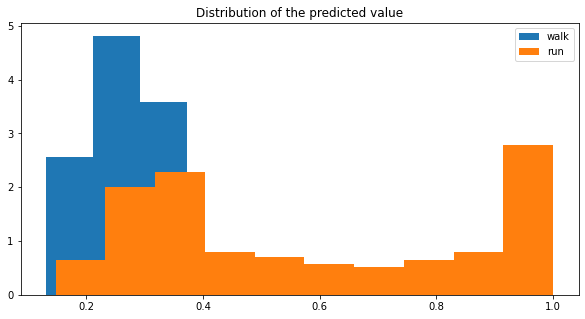

In [25]:
_ = plt.hist(cnn_scale.predict(xtest2)[np.where(ytest == 0.)[0]], label="walk", density=True)
_ = plt.hist(cnn_scale.predict(xtest2)[np.where(ytest == 1.)[0]], label="run", density=True)
_ = plt.title("Distribution of the predicted value")
_ = plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

## Create a tflite model

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
tflite_model = converter.convert()
_ = open("analysis/trained_model/conv/global.tflite", "wb").write(tflite_model)  # Save the tf-lite model

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpokow8qqm/assets


In [27]:
interpreter = tf.lite.Interpreter("analysis/trained_model/conv/global.tflite")  # Load the lite model
interpreter.allocate_tensors()

In [28]:
input_details = interpreter.get_input_details()[0]['index']
output_details = interpreter.get_output_details()[0]['index']

In [29]:
y = []
for _ in xtest:
    x = tf.convert_to_tensor([_], dtype=tf.float32)
    interpreter.set_tensor(input_details, x)
    interpreter.invoke()
    y += [interpreter.get_tensor(output_details)[0][0]]

y = np.array(y)

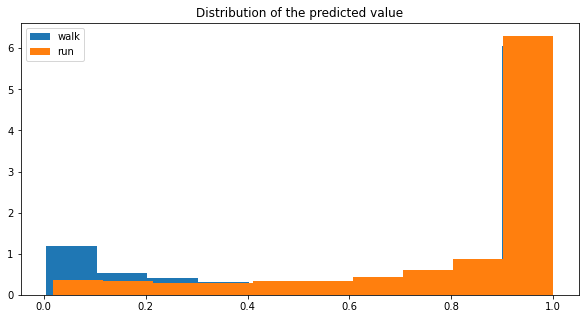

In [30]:
_ = plt.hist(y[np.where(ytest == 0.)[0]], label="walk", density=True)
_ = plt.hist(y[np.where(ytest == 1.)[0]], label="run", density=True)
_ = plt.title("Distribution of the predicted value")
_ = plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [31]:
confusion_matrix(ytest, np.where(y >.5, 1, 0))

array([[2171, 5885],
       [ 479, 2555]])